# Mining & Analyzing a Twitter Network


# Objective 
Creating a real network using data collected from the Internet and then to invetsigating to discover some properties of the collected network. 

# API 

I've used the following API and docs

* [Twitter REST API](https://dev.twitter.com/rest/public)
* [Tweepy Documentation](http://tweepy.readthedocs.io/en/v3.5.0/)
* [Tutorial "Mining Twitter data with Python"](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)

# 1. Collecting The Twitter Network

- Registered a [client application with Twitter](https://apps.twitter.com/).
- Credentials stored in `credentials.ini` file as follows:
```
[twitter]
consumer_key = YOUR-CONSUMER-KEY
consumer_secret = YOUR-CONSUMER-SECRET
access_token = YOUR-ACCESS-TOKEN
access_secret = YOUR-ACCESS-SECRET
```
Not published for security concerns.

In [1]:
%matplotlib inline

import random
import configparser
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import tweepy  # you will need to install tweepy first

In [2]:
# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')

#authentication
auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))

#construct API instance
#deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Collecting data from Twitter! 

I construct the network with the using following structure:

- Choosing a `user_id` in Twitter to be our first node. 

- Finding (some) of the users who are both following `user_id` and are being followed by user_id (i.e. friends of uder_id). These are my first_nodes.

- For every node in the list `first_nodes` finding (some) of the users who are following and are being followed by this node (aka the connections of this node). These are the `second_nodes`.

- The collection of the ids of all nodes (aka Twitter users) that we have collected so far will be placed in a list called `all_nodes`.

- Since, I have only collected a subset of all possible "connections" for our nodes, I am checking if there are any remaining inner connections that are have missed.

The entire network is organized in a dictionary with entries that will have as key the Twitter id of the user (this is a number characterizing each user in Twitter) and as value the list of ids of his connections.

I have chosen the Twitter account of [Applied Machine Learning Days](https://www.appliedmldays.org) that will take place in January 2018 in EPFL. 

In [3]:
user = 'appliedmldays '
user_id=api.get_user(user).id
user_id

763052115392593920

Returns a list with the **ids** of the passed user_id connections. 
Taking into account the case where a user is 'protected'


In [4]:
def find_connections(user_id):
    if(api.get_user(user_id).protected == True): #Return an empty list if user is protected
        print('Protected node ',user_id)
        return []
    #followers = api.followers_ids(user_id)
    followers = []
    friends = []
    for page in tweepy.Cursor(api.followers_ids, id=user_id).pages(5): #limiting to 5
        followers.extend(page)
    for page in tweepy.Cursor(api.friends_ids, id=user_id).pages(5): #limiting to 5
        friends.extend(page)
    #friends= api.friends_ids(user_id)
    connections = set(followers).intersection(set(friends)) 
    if(list(connections) == 0):  #The case where there are no followers. Not found in my trial. 
        print('NULL NODE! ',user_id)
        return []
    return list(connections)


In [5]:
first_connections=find_connections(user_id)
print('{} has {} connections'.format(user, len(first_connections)))

Rate limit reached. Sleeping for: 46
appliedmldays  has 139 connections


Collecting `first_nodes` and `second_nodes` and organizing their connections in the dictionary called `network`.

In [7]:
network={}
tosaverequests = {user_id : find_connections(user_id)} #tosaverequests is a dictionary DB for API calls.
chosen = 0 #Keeping track of the number of added nodes.
how_many=10#This is the number of connections you are sampling. 
          #Keep small (e.g.3) for development, larger later (e.g. 10)
second_nodes=[]
neighbors = []
random.shuffle(tosaverequests[user_id]) #Shuflling randomly once and then taking the top how_many is same as using random.sample
for firstuser in tosaverequests[user_id]: #For adding first nodes.
    print('Processing the potential first user ',firstuser) #To keep track of the process
    if(chosen >= how_many):   #In case the number of connections is more then what we need.
        break
    temp = find_connections(firstuser)
    if(len(temp) > 0): #Only add if not null or protected.
        chosen += 1 
        tosaverequests[firstuser] = temp    #Adding API call to DB
        neighbors.append(firstuser)     #the neigbors is the list of chosen firstusers
print('Completed First nodes')
first_nodes = neighbors
network[user_id] = neighbors   #Adding root node to the network

for user in first_nodes:   #Adding second nodes for each node in first node.
    print('Adding second users for the first user', user)
    random.shuffle(tosaverequests[user]) #This makes sure the chosen nodes are random
    chosen = 0 #Keeping track of total chosen for each first node
    neighbors = []
    for secuser in tosaverequests[user]: #choosing the nodes that are not protected or have 0 connections.
        print('Added number of second nodes for the ongoing firstuser', chosen)
        if(chosen >= how_many): #In case, number of connections is more than how many
            break 
        if secuser in tosaverequests.keys(): #Saving the API Call if already seen. Fetch from DB
            second_nodes.append(secuser)
            neighbors.append(secuser)
        else:
            temp = find_connections(secuser) #Get the connections.
            if(len(temp) > 0):
                chosen += 1 
                second_nodes.append(secuser) #append the chosen node.
                tosaverequests[secuser] = temp #Adding to DB only is not protected/or 0 connections. 
                neighbors.append(secuser)
    network[user] = neighbors #Add the chosen nodes to the network.

second_nodes = list(set(second_nodes).difference(set(first_nodes).union({user_id}))) #To remove the duplicate nodes and first nodes in second_nodes


Processing the potential first user  140856473
Processing the potential first user  19269506
Processing the potential first user  85425543
Processing the potential first user  83657910
Processing the potential first user  1275985766
Processing the potential first user  636864273
Processing the potential first user  54164492
Processing the potential first user  272924750
Processing the potential first user  840295508899950592
Processing the potential first user  850645992
Processing the potential first user  123969580
Completed First nodes
Adding second users for the first user 140856473
Added number of second nodes for the ongoing firstuser 0
Added number of second nodes for the ongoing firstuser 1
Added number of second nodes for the ongoing firstuser 2
Added number of second nodes for the ongoing firstuser 3
Added number of second nodes for the ongoing firstuser 4
Rate limit reached. Sleeping for: 886
Added number of second nodes for the ongoing firstuser 5
Added number of second nod

In [10]:
pprint(network)

{19269506: [57859591,
            162228597,
            632003260,
            171511959,
            167747185,
            867412497086787585,
            2751481575,
            297121735,
            14059304,
            135488979],
 54164492: [2248163412,
            14813790,
            313347757,
            310809326,
            15197597,
            2737225663,
            140975570,
            226108703,
            69810474,
            1876193864],
 83657910: [2811494825,
            3180164538,
            15455122,
            293437768,
            101051403,
            9517462,
            14375294,
            2332107884,
            14541608,
            22477880],
 85425543: [704567443314839552,
            128663787,
            85783864,
            822463136745869316,
            4469439315,
            21320370,
            272945802,
            2304650466,
            269922371,
            14105423],
 140856473: [330391433,
             733238893,
      

# To save repeating the work in case something goes wrong. Pickle!

import pickle <br>
pickle.dump(network , open( "netfor10.p", "wb" ))  <br> 
pickle.dump(tosaverequests , open("apicallsfor10.p","wb")) 

In [11]:
all_nodes= first_nodes + second_nodes + [user_id]

In [12]:
print('There are {} first hop nodes'.format(len(first_nodes)))
print('There are {} second hop nodes'.format(len(second_nodes)))
print('There are overall {} nodes in the collected network'.format(len(all_nodes)))

There are 10 first hop nodes
There are 92 second hop nodes
There are overall 103 nodes in the collected network


In [13]:
for i in second_nodes:
    network[i]=[]

Finding the inner connections between the collected nodes that might have been missed because of sampling the connections.

In [14]:
for user_id in all_nodes:
    network[user_id].extend([node for node in all_nodes if node in tosaverequests[user_id]]) #Adding all nodes that are connected to user_d and are in the gaph
    network[user_id] = list(set(network[user_id]))    #Removes duplicates

# 2. Investigating some of the properties of the collected network

## 2.1 Adjacency matrix

Transforming dictionary into the adjacency (or weight) matrix. 

In [15]:
W=np.zeros([len(all_nodes),len(all_nodes)], dtype=int)

In [17]:
for i,node in enumerate(all_nodes):
    W[i,:] = [int(node1 in network[node]) for node1 in all_nodes]

Usuaally, the weight matrix should be symmetric. But here, it is not because of the following reason:

For the number of API calls to be manageable and code to run in reasonable time, I had limit the number of page requests by tweepy cursor to 5 for request of each followers and friends. Due, to this it is possible that a user $i$ (already in the network) is a connection to user $j$ and hence added user $j$ to the network but user j is a hub and consequently, the api calls got limited and I did not retrieve the complete list of connections for user $j$. Now, while preaparing the $W$ adjacency matrix, I would add a $1$ at $W(i,j)$ but $0$ at $W(j,i)$ because $W(j,i)$ is put looking only at the stored connections of user j. Thus, due to limiting the number of requests $W$ might end up being asymmetric. However, this can be taken care of, as is done in the following snippets.

However, the following situation cannot be rectified due to no information on either position $(i,j)$ or $(j,i)$. Suppose, $i$ and $j$ are both second_nodes and for both the max. number of pages was reached and neithe of them gets added to other's list of connections.Consequently, both $W(i,j)$ and $W(j,i)$ would end up being $0$ which cannot be corrected without additional API calls.

In [19]:
np.nonzero(W-W.transpose())

(array([ 1,  3,  7,  9, 16, 17, 32, 37, 37, 37, 37, 37, 37, 38, 42, 52, 56,
        56, 57, 57, 57, 57, 57, 57, 58, 65, 77, 80, 81, 88], dtype=int64),
 array([52, 56, 57, 37, 57, 57, 37,  9, 32, 42, 77, 80, 88, 57, 37,  1,  3,
        65,  7, 16, 17, 38, 58, 81, 57, 56, 37, 37, 57, 37], dtype=int64))

In [20]:
# Make W is symmetric
bigger = W.transpose() > W

In [21]:
W = W - W*bigger + W.transpose()*bigger

Plotting the weight matrix of your collected network.


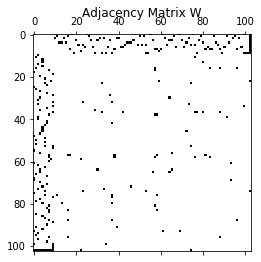

In [22]:
# your code here
plt.spy(W)
plt.title('Adjacency Matrix W')

In [23]:
print('Number of links here: ',sum(sum(W != 0))/2)
print('Maximum number of links: ',((how_many**2 + how_many+1)*(how_many**2 + how_many))/2)

Number of links here:  140.0
Maximum number of links:  6105.0


## 2.2 Degrees distribution

In [30]:
p = np.sum(W, axis = 0)

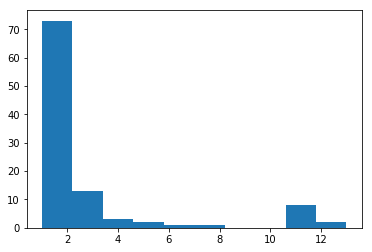

In [31]:
plt.hist(p);

## 2.3 Average degree

In [34]:
d_avg = np.mean(p)
d_avg

2.7184466019417477

## 2.4 Pruning the collected network

Pruning the collected network keeping only the nodes that have a degree that is greater than the average degree.

In [32]:
Wpruned = W[[[i] for i,elt in enumerate(p>np.mean(p)) if elt] , p>np.mean(p)] #Awesome numpy array slicing!

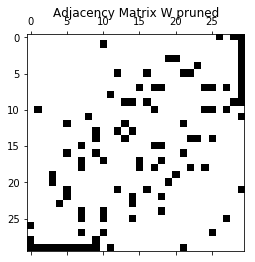

In [35]:
plt.spy(Wpruned)
plt.title('Adjacency Matrix W pruned');

## This was done to practice API and Tweepy and gain insights into the real world social networks and their sparsity properties.